City Map

In [2]:
import shapely
print(shapely.__version__)
# print(ig.__version__)

import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd

place = 'St. Louis, Missouri, USA'

G_nx = ox.graph_from_place(place, network_type='drive')

nodes, streets = ox.graph_to_gdfs(G_nx)
streets.head()

# create networkx graph
G_nx = nx.relabel.convert_node_labels_to_integers(G_nx)

2.0.2


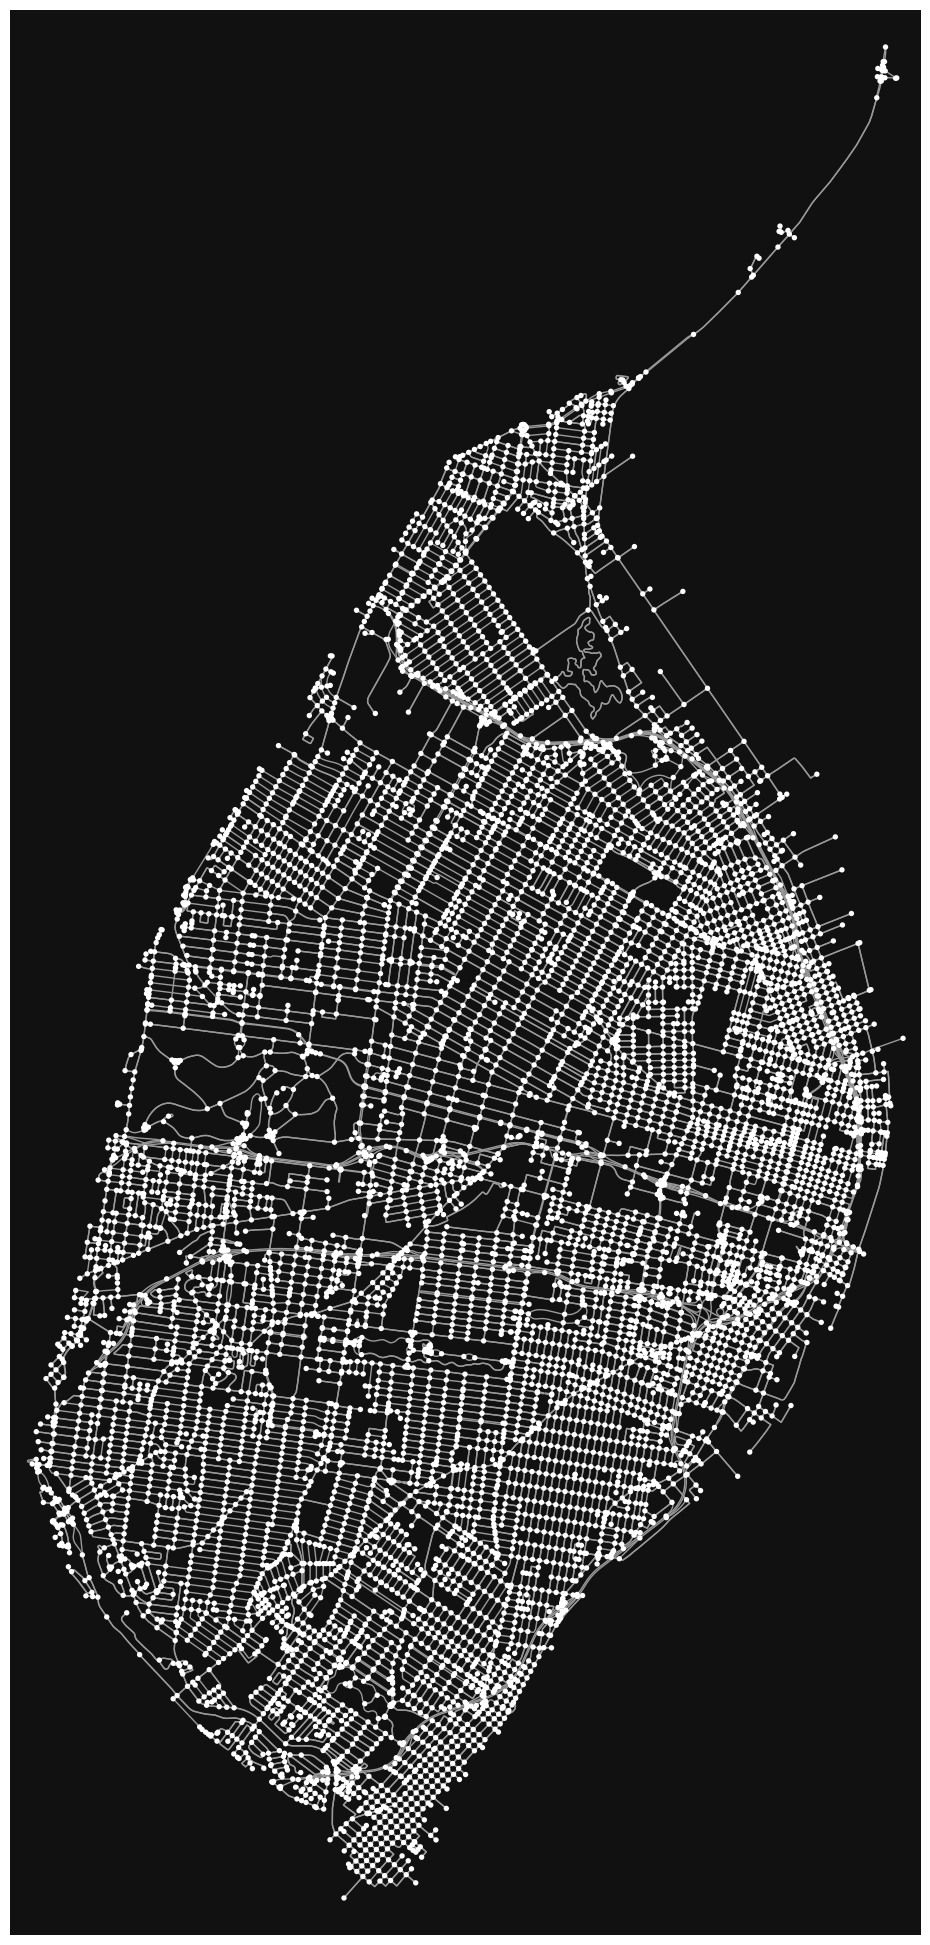

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# Get the edges along the shortest path
path_edges = ox.plot_graph(G_nx, figsize = (25,25))

# Show the plot
plt.show()

In [4]:
import networkx as nx
from geopy.distance import geodesic

import igraph as ig
import networkx as nx
import numpy as np
import osmnx as ox

def get_origin_destination_node(coords_origin, coords_destination):
    # Find the nearest nodes in the graph to the specified coordinates
    origin_node = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), coords_origin).kilometers)
    destination_node = min(G_nx.nodes, key=lambda node: geodesic((G_nx.nodes[node]['y'], G_nx.nodes[node]['x']), coords_destination).kilometers)

    print(f"Starting node: {origin_node}")
    print(f"Destination node: {destination_node}")

    return origin_node, destination_node


Get severities in runtime from triggering model with coordinates and random values

In [26]:
import subprocess
import os
import random 

def get_severity(lat, lon):
    # lat = 38.627003
    # lon = -90.199402
    elapsed_time = random.randint(1,30)
    day_of_week = 1
    hour_of_day = random.uniform(7.0, 7.5)
    time_period = "morning"
    Temperature = random.uniform(22, 26)
    Humidity = random.uniform(55, 65)
    Pressure = random.uniform(0.9, 1.02)
    Visibility = random.uniform(5, 20)
    Wind_Direction = 'N'
    Wind_Speed = random.uniform(5, 15)
    Weather_Condition = random.choice("rain", "cloudy", "mist", "clear")
    Sunrise_Sunset = "Day"
    Civil_Twilight = "Day"
    Nautical_Twilight = "Day"
    Astronomical_Twilight = "Day"

    input_value = f"--Start_Lat {lat} --End_Lng {lon} --elapsed_time {elapsed_time} --day_of_week {day_of_week} --hour_of_day {hour_of_day} --time_period {time_period} --Temperature {Temperature} --Humidity {Humidity} --Pressure {Pressure} --Visibility {Visibility} --Wind_Direction {Wind_Direction} --Wind_Speed {Wind_Speed} --Weather_Condition {Weather_Condition} --Sunrise_Sunset {Sunrise_Sunset} --Civil_Twilight {Civil_Twilight} --Nautical_Twilight {Nautical_Twilight} --Astronomical_Twilight {Astronomical_Twilight}"

    # Specify the folder path
    folder_path = '/home/tests/MEIA-8-T2/AAUT1IA_final/14_presentation'

    # Change the working directory
    os.chdir(folder_path)

    # Split the string into a list of arguments
    arguments = input_value.split()

    # print(arguments)
    # Run with inputs and capture output
    result = subprocess.run(['python3', 'predict_severity_aautia_project_inputs.py'] + arguments, stdout=subprocess.PIPE)

    # Decode and print the output
    output_lines = result.stdout.decode('utf-8').splitlines()

    # Print the last line
    if output_lines:
        severity = output_lines[-1]
        return severity

In [31]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

def find_node_severity(node):
    lat = G_nx.nodes[node]['y']
    lon = G_nx.nodes[node]['x']
    return get_severity(lat, lon)

def find_graph_severity(graph):
    severities_per_node = [find_node_severity(node) for node in graph.nodes]
    return severities_per_node

severities_r = find_graph_severity(G_nx)

In [104]:
df = pd.DataFrame(np.array(severities_r))
df.to_csv("/home/tests/genetic_tests/severities.csv",  header=False, index=False)

In [128]:
# Read the CSV file
df = pd.read_csv('/home/tests/genetic_tests/severities.csv')

# Flatten the resulting 2D array to a 1D array
severities_r = df.astype(int).to_numpy().flatten()

Get severities from closest distance to data from poins in dataset that wererun with ML model

In [127]:
df_severities = pd.read_csv("/home/tests/genetic_tests/severities_data/df_with_coord_and_predictions2.csv")

In [ ]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

Graph = G_nx

def find_node_severity(node, df_severities):
    lat = Graph.nodes[node]['y']
    lon = Graph.nodes[node]['x']

    # Vectorized calculation of geodesic distances
    distances = np.vectorize(lambda lat, lon: geodesic((lat, lon), (lat, lon)).kilometers)(df_severities['Start_Lat'], df_severities['Start_Lng'])

    # Find the index of the minimum distance
    closest_idx = np.argmin(distances)

    return df_severities.loc[closest_idx, 'prediction']

def find_graph_severity(graph, df_severities):
    severities_per_node = [find_node_severity(node, df_severities) for node in graph.nodes]
    return severities_per_node

severities_r = find_graph_severity(Graph, df_severities)
df = pd.DataFrame(np.array(severities_r))
df.to_csv("/home/tests/genetic_tests/predictions.csv",  header=False, index=False)

In [11]:
# Read the CSV file
df = pd.read_csv('/home/tests/genetic_tests/predictions.csv')

# Flatten the resulting 2D array to a 1D array
severities_r = df.astype(int).to_numpy().flatten()

Genetic Algorithm

In [93]:
import random

import networkx as nx
import matplotlib.pyplot as plt
import random
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic

AVERAGE = True

Graph = G_nx

def get_path_severities(path):
    severities = []
    for node in path:
        node_sev = 1
        try:
            node_sev = severities_r[node] #find_node_severity(node)
        except:
            pass
        severities.append(float(node_sev))
    return severities

def generate_random_path(graph, start_node, end_node, explore_prob=0.6, max_nodes=500):
    q = []
    visited = set()

    q.append([start_node])

    while q:
        current_path = q.pop(0)
        last_node = current_path[-1]

        if last_node == end_node:
            return current_path

        if last_node not in visited:
            neighbors = list(graph.neighbors(last_node))

            for neighbor in neighbors:
                if random.random() < explore_prob:
                    new_path = list(current_path)
                    new_path.append(neighbor)
                    q.append(new_path)

            visited.add(last_node)

    return generate_random_path(graph, start_node, end_node)

def calculate_distance(path):
    total_distance = 0

    for node1, node2 in zip(path[:-1], path[1:]):
        coord1 = [Graph.nodes[node1]['y'], Graph.nodes[node1]['x']]
        coord2 = [Graph.nodes[node2]['y'], Graph.nodes[node2]['x']]

        # Function to calculate the haversine distance between two coordinates in (latitude, longitude) format
        R = 6371  # Earth radius in kilometers

        lat1, lon1 = radians(coord1[1]), radians(coord1[0])
        lat2, lon2 = radians(coord2[1]), radians(coord2[0])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        total_distance += distance  # Accumulate distance for each segment

    return total_distance  # Return the total distance for the entire path

def initialize_pop(POP_SIZE, TARGET):

    start_node = TARGET[0][0]
    destination_node = TARGET[0][1]

    population = list()

    i = 0
    while i < POP_SIZE:
        random_path = generate_random_path(Graph, start_node, destination_node)
        random_path_severities = get_path_severities(random_path)
        population.append([random_path, random_path_severities, fitness_cal_len(random_path), fitness_cal_sev(random_path_severities)])
        i += 1

    return population


def selection(population):
    # Sorting the paths based on safety
    safest_paths = sorted(population, key=lambda x: x[-1])
    
    # Calculating the index to get percentage of the safest paths
    selected_part = int(0.25 * len(safest_paths))
    if selected_part == 0:
        selected_part = 1

    # Selecting the top of safest paths
    selected_paths = safest_paths[:selected_part]
    
    # Sorting the selected paths based on length
    selected_paths = sorted(selected_paths, key=lambda x: x[-2])

    return selected_paths


def fitness_cal_sev(path_severities):
    global AVERAGE
    path_len = 0
    if AVERAGE:
        path_len = np.mean(path_severities)
    else:
        path_len = sum(path_severities)
    # print(path_len)
    return path_len

def fitness_cal_len(path):
    path_len = calculate_distance(path)
    return path_len


def find_common_point(path1, path2):
    # Find all common points between two paths
    common_points = [node for node in path1 if node in path2]

    if not common_points:
        return None  # No common points found

    # Select the middle point
    middle_index = len(common_points) // 2
    middle_point = common_points[middle_index]

    return middle_point

def merge_path(path1, path2):
    common_point = find_common_point(path1, path2)
    if common_point:
        if random.choice([True, False]):  # Randomly decide which path comes first
            index_path1 = path1.index(common_point)
            index_path2 = path2.index(common_point)

            return path1[:index_path1] + path2[index_path2:]
        else:
            index_path2 = path2.index(common_point)
            index_path1 = path1.index(common_point)

            return path2[:index_path2] + path1[index_path1:]

def crossover(population):
    crossovered = []
    for path1 in population:
        
        # randomly pick second parent
        path2 = random.choice(population)

        # take only nodes
        path1 = path1[0]
        path2 = path2[0]

        # Merge two paths by combining the first half of path1 with the second half of path2
        merged_path = merge_path(path1, path2)
        path_severities = get_path_severities(merged_path)
        crossovered.append([merged_path, path_severities, fitness_cal_len(merged_path), fitness_cal_sev(path_severities)])
    
    return crossovered

def geodesic_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

def mutate_path(path, max_distance_factor):
    try:
        for _ in range(5):  # Try up to 5 times to find a suitable mutation
            # Calculate the maximum allowed distance between random points
            max_distance = max_distance_factor * len(path)

            # Choose the first random point
            random_p1 = random.choice(path)

            # Find a candidate for the second random point within the allowed distance
            candidate_points = [node for node in path if geodesic_distance(G_nx.nodes[random_p1]['y'], G_nx.nodes[random_p1]['x'], G_nx.nodes[node]['y'], G_nx.nodes[node]['x']) <= max_distance]

            if not candidate_points:
                continue  # No suitable candidates found, try again

            # Choose the second random point from the candidate points
            random_p2 = random.choice(candidate_points)

            random_path = generate_random_path(G_nx, random_p1, random_p2)
            
            if random_path is not None:
                # Successful mutation, return the modified path
                return path[:path.index(random_p1)] + random_path + path[path.index(random_p2) + 1:]
    except:
        pass
    # No successful mutation, return the original path
    return path

def mutate(population, max_distance_factor):
    mutated = []
    for path in population:
        # take only nodes
        path = path[0]
        mutated_path = mutate_path(path, max_distance_factor)
        path_severities = get_path_severities(mutated_path)
        mutated.append([mutated_path, path_severities, fitness_cal_len(mutated_path), fitness_cal_sev(path_severities)])
    return mutated
    

def replace(new_gen, population):
    # print(population)
    try:
        for idx in range(len(population)):
            if population[idx][2] > new_gen[idx][2]: #if len of new_gen is smaller
              population[idx][0] = new_gen[idx][0] # path nodes
              population[idx][1] = new_gen[idx][1] # severities 
              population[idx][2] = new_gen[idx][2] # sum of severities
    except:
        pass
    return population

def genetic_algorithm(POP_SIZE, MUT_RATE, TARGET, GENES, MAX_GENERATIONS, average):
    global AVERAGE
    if average:
        AVERAGE = True
    # 1) initialize population
    population = initialize_pop(POP_SIZE, TARGET)

    generation = 1

    # now population has 2 things, [chromosome, fitness]
    # 3) now we loop until TARGET is found
    while generation <= MAX_GENERATIONS:
        
        # 3.1) select best people from current population
        selected = selection(population)
        
        # 3.2) mate parents to make new generation
        # population = sorted(selected, key= lambda x:x[2])
        crossovered = crossover(selected)
            
        # 3.3) mutating the childeren to diversfy the new generation
        mutated = mutate(crossovered, MUT_RATE)
                
        # 3.4) replacement of bad population with new generation
        # we sort here first to compare the least fit population with the most fit new_gen
        population = replace(mutated, population)
        population = sorted(selected, key= lambda x:x[-1])
        
        generation+=1
        population = selected

    return population[0][0] # return the path that has the smallest sum of severities

In [7]:
# Set the source and target coordinates
start_coordinates = (38.664172, -90.259974)
destination_coordinates = (38.625559, -90.210021) 

TARGET = [get_origin_destination_node(start_coordinates, destination_coordinates)]

Starting node: 4341
Destination node: 6377


Run path generation chosing with smallest average of severities

Distance of the path 8.954611282645423


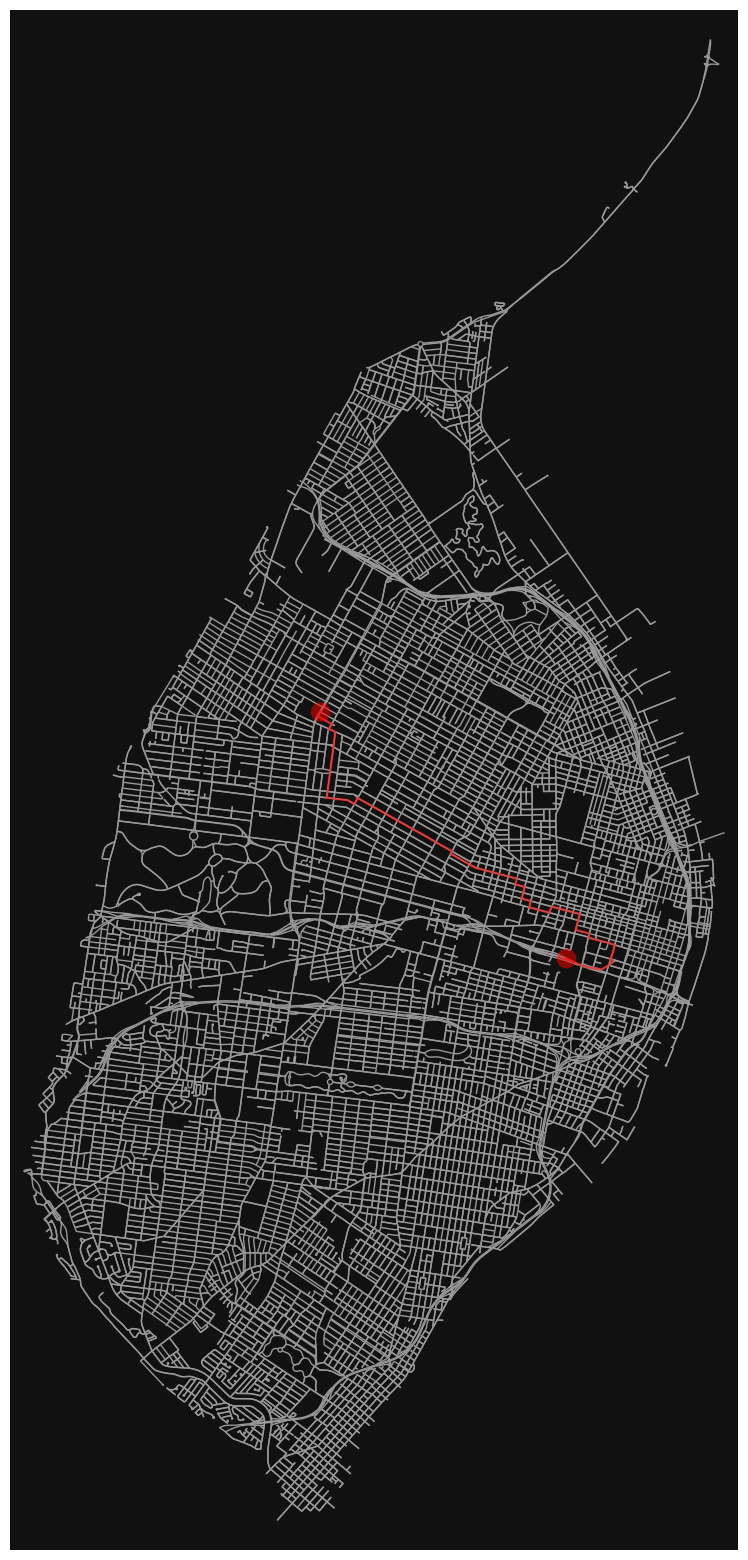

In [94]:
POP_SIZE = 100
MUT_RATE = 0.2
MAX_GENERATIONS = 50
AVERAGE = True

best_path = genetic_algorithm(POP_SIZE, MUT_RATE, TARGET, Graph, MAX_GENERATIONS, AVERAGE)

print(f"Distance of the path {calculate_distance(best_path)}")

# Get the edges along the shortest path
ox.plot_graph_route(G_nx, best_path, route_color='r', orig_dest_size=200, route_linewidth=2, show=True, node_size=0, figsize=(20,20))

# Show the plot
plt.show()

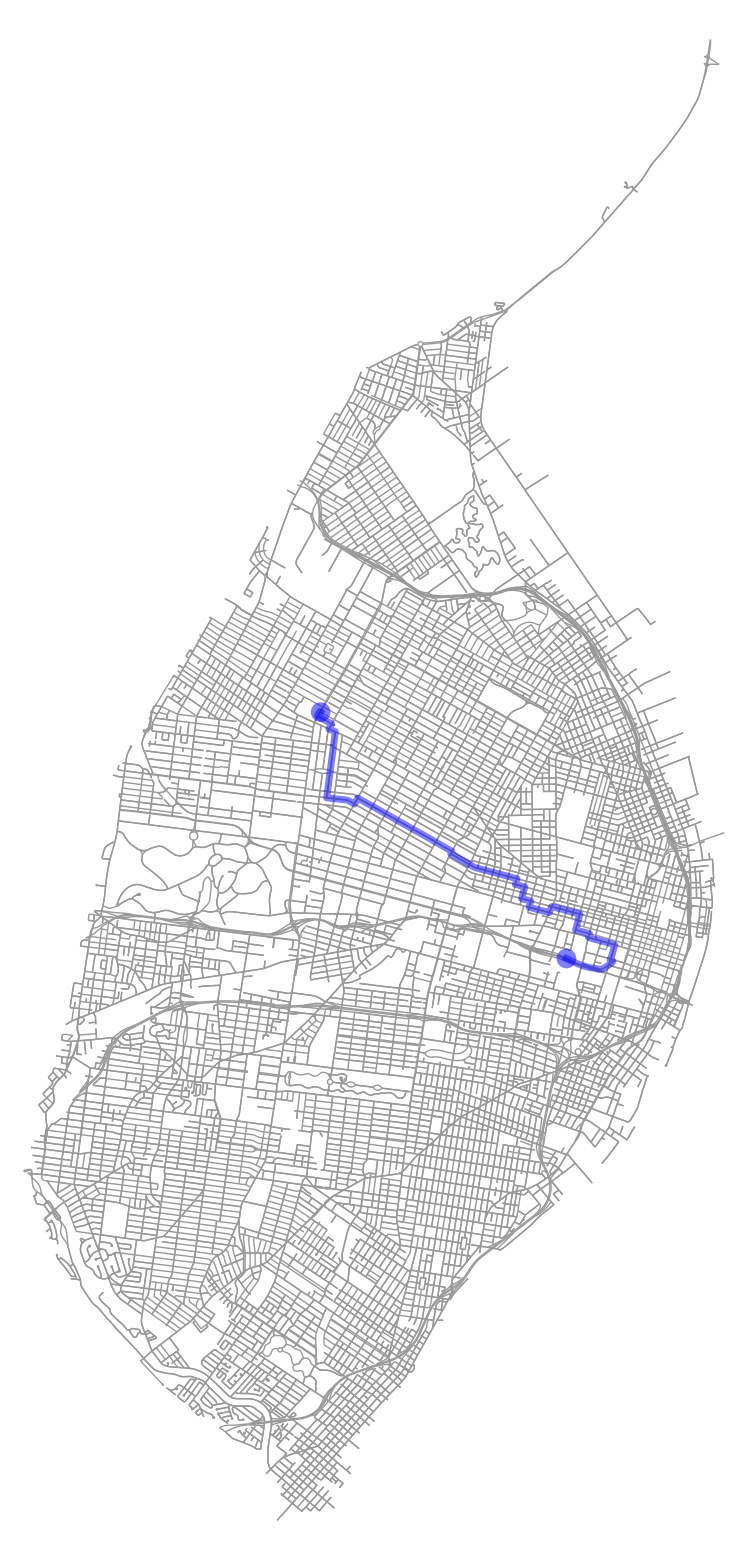

In [98]:
# Get the edges along the shortest path
# ox.plot_graph_route(G_nx, best_path, route_color='b', orig_dest_size=200, route_linewidth=2, show=True, node_size=0, figsize=(20,20))
ox.plot_graph_route(G_nx, best_path, route_color='b', orig_dest_size=200, route_linewidth=5, show=True, node_size=0, figsize=(20,20), bgcolor='w')

# Show the plot
plt.show()

Test it pathes are random and merge pathes

In [115]:
# Get the edges along the shortest path
path1 = generate_random_path(Graph, TARGET[0][0],TARGET[0][1])
path2 = generate_random_path(Graph, TARGET[0][0],TARGET[0][1])


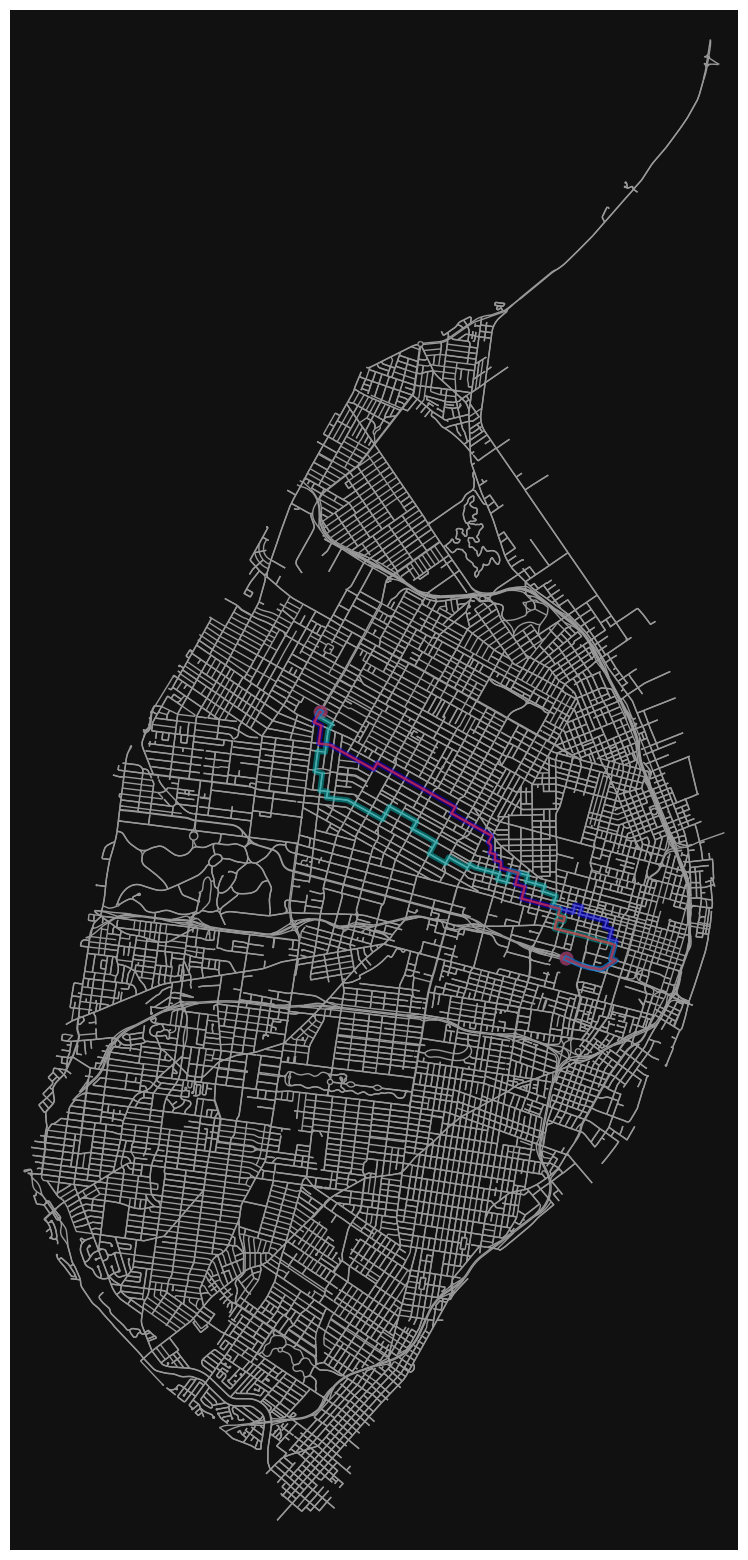

In [128]:
merged_path = merge_path(path1, path2)

routes = [path1, path2, merged_path]
rc = ['b', 'c', 'r']
rl = [4, 4, 2]
fig, ax = ox.plot_graph_routes(Graph, routes, route_colors=rc, route_linewidths=rl, node_size=0, figsize=(20,20))

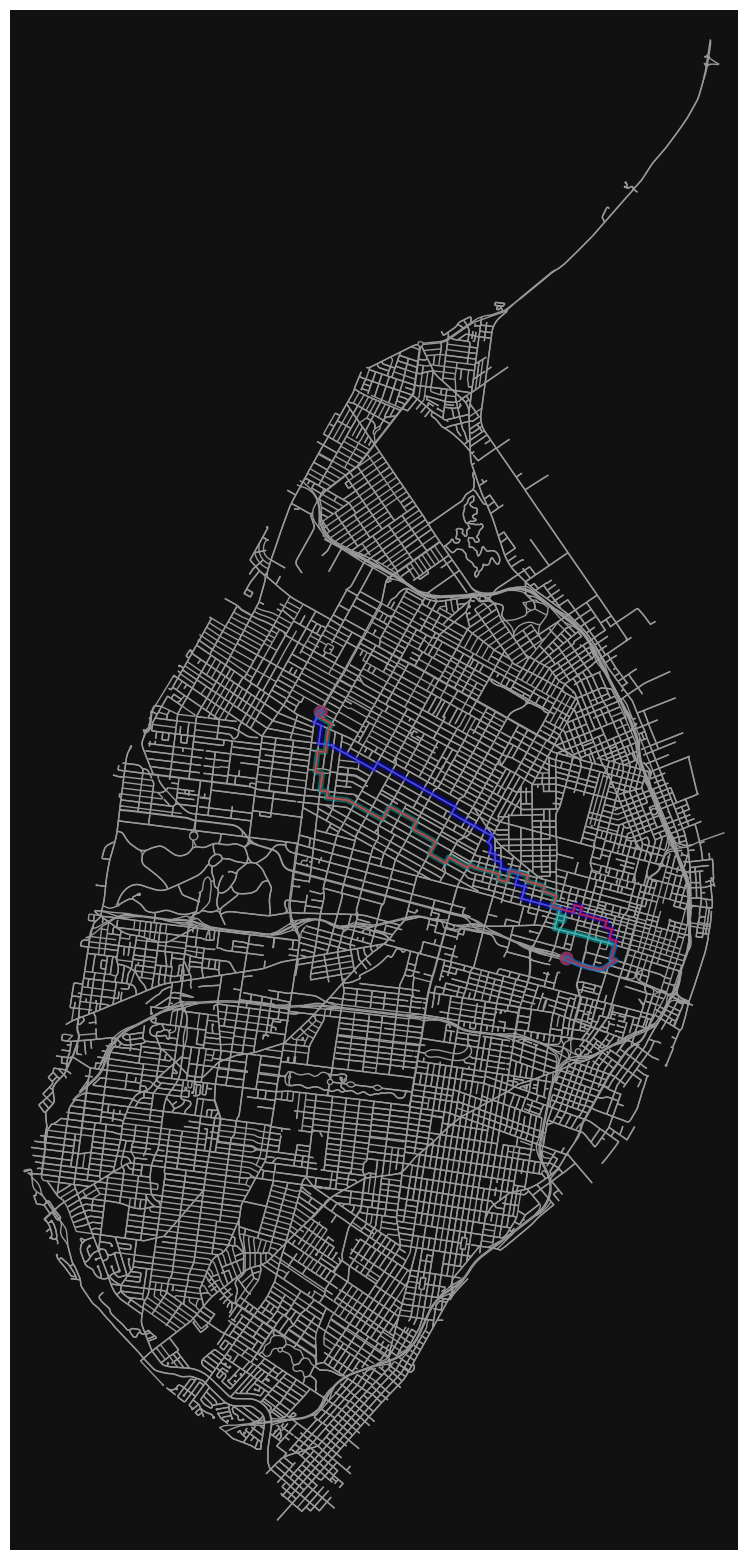

In [130]:
merged_path = merge_path(path1, path2)

routes = [path1, path2, merged_path]
rc = ['b', 'c', 'r']
rl = [4, 4, 2]
fig, ax = ox.plot_graph_routes(Graph, routes, route_colors=rc, route_linewidths=rl, node_size=0, figsize=(20,20))

Verify mutation

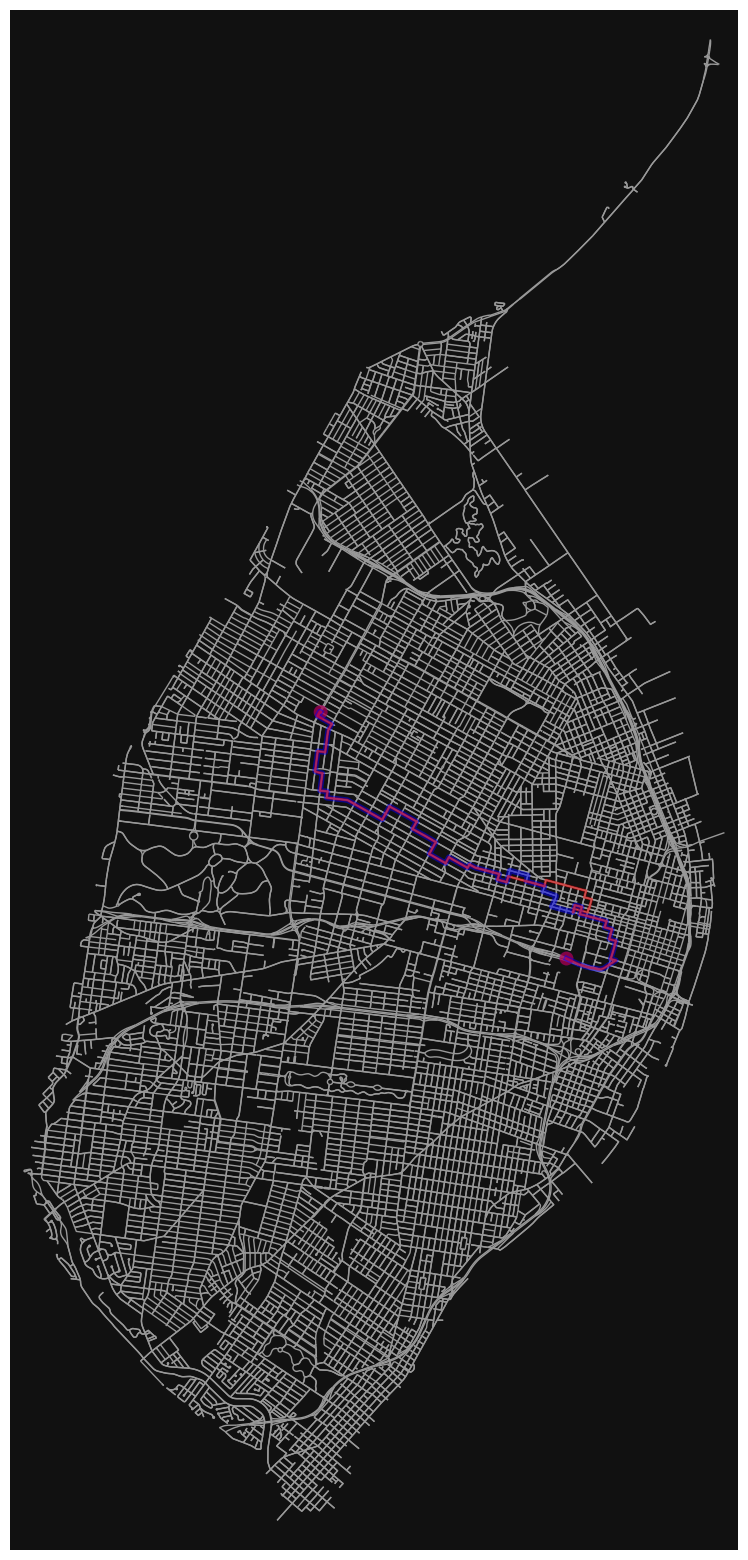

In [164]:
mutated_path = mutate_path(merged_path, 0.2)

routes = [merged_path, mutated_path]
rc = ['b', 'r']
rl = [4, 2]
fig, ax = ox.plot_graph_routes(Graph, routes, route_colors=rc, route_linewidths=rl, node_size=0, figsize=(20,20))